In [1]:
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image , ImageOps ,ImageDraw, ImageColor , ImageFont
import numpy as np
import matplotlib.pyplot as plt

import tempfile
from urllib.request import urlopen
from io import BytesIO


In [2]:
def display_image(image):
  plt.figure(figsize=(8,10))
  plt.axis('off')
  plt.grid(False)
  plt.imshow(image)



def download_and_resize_image(url, new_width=256 , new_height=256 , display=False):

  _ , filename = tempfile.mkstemp(suffix='.jpg')
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)

  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.LANCZOS)

  pil_image_rgb = pil_image.convert('RGB')
  pil_image_rgb.save(filename, format='JPEG', quality=90)

  print( f'Image downloaded to { filename}')

  if display:
     display_image(pil_image)

  return filename

def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color, font, display_str_list=(), thickness=4):

    draw = ImageDraw.Draw(image)
    image_width, image_height = image.size

    left, right, top, bottom = xmin * image_width, xmax * image_width, ymin * image_height, ymax * image_height


    draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)],
              width=thickness, fill=color)

    display_str_heights = [font.getbbox(ds)[3] for ds in display_str_list]

    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height

    for display_str in display_str_list[::-1]:

        bbox = font.getbbox(display_str)
        text_width, text_height = bbox[2], bbox[3]

        margin = np.ceil(0.05 * text_height)

        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                       fill=color)

        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill="black",
                  font=font)

        text_bottom -= text_height + 2 * margin



def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf", 25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"), int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(image_pil, ymin, xmin, ymax, xmax, color, font, display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))

    return image



Image downloaded to /tmp/tmpscf5kytk.jpg


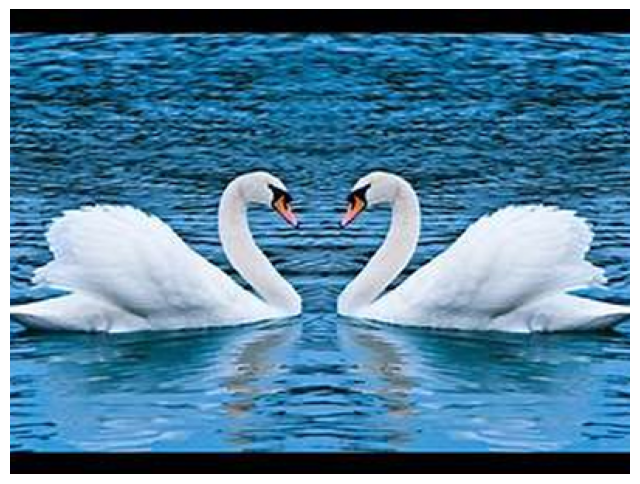

In [3]:

image_url = "https://tse1.mm.bing.net/th/id/OIP.agFmpt0La0arYWu7dr2cPwHaEo?pid=Api&P=0&h=220"
downloaded_image_path = download_and_resize_image(image_url, 400, 300, True)

In [10]:
detector = hub.load('https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1').signatures['default']

In [9]:
image = np.array(Image.open(downloaded_image_path))
converted_image = tf.image.convert_image_dtype(image , tf.float32)[tf.newaxis , ...]

In [12]:
result = detector(converted_image)
result = { key : value.numpy() for key , value in result.items()}

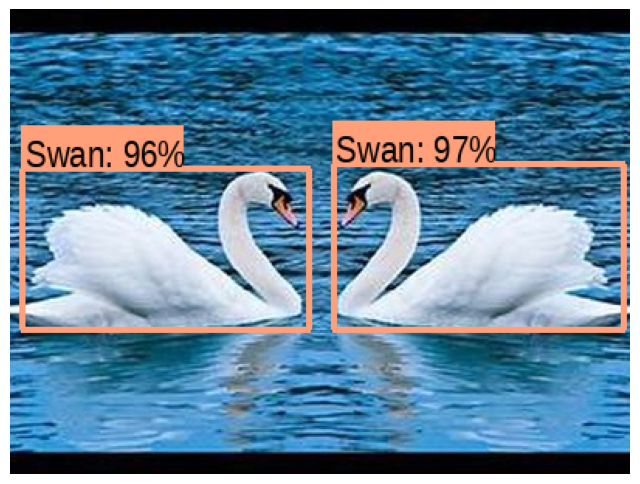

In [14]:
image_with_boxes = draw_boxes ( image.copy() , result['detection_boxes'] , result['detection_class_entities'], result['detection_scores'] , max_boxes=10,
    min_score=0.5  )

display_image (image_with_boxes)